# Pretrained Vectors - Neural Network Classifier

In this notebook, we try various merging strategies to merge the vectors for image pair inputs and try to predict similarity using a fully connected neural network front end.

In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras import optimizers
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy import spatial

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "/"
IMAGE_DIR = os.path.join(DATA_DIR, "images_after_crop")
TEST_B_DIR = os.path.join(DATA_DIR, "pigtest_b")

BATCH_SIZE = 32
NUM_EPOCHS = 20

In [3]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join("/vector_data/", "resnet-vectors-cropped-images.tsv")
VECTOR_FILE_TEST_B = os.path.join("/vector_data/", "resnet-vectors-test-b.tsv")

In [4]:
def get_test_b_triples(image_dir, test_b_dir):
    test_b_triples = []
    image_names_rev = [x for x in os.listdir(image_dir) if not (x.startswith('.'))]
    test_b_names = [x for x in os.listdir(test_b_dir) if not (x.startswith('.'))]
    for test_b_name in test_b_names:
        for image_name in image_names_rev:
            test_b_triples.append((test_b_name, image_name, 0))
    return test_b_triples

In [71]:
def get_pig_triples_new(image_dir):
    image_groups = {}
    image_names_rev = [x for x in os.listdir(image_dir) if not (x.startswith('.'))]
    for image_name in image_names_rev:
        base_name = image_name[0:-6]
        group_name = base_name[0:2]
        if image_groups.has_key(group_name):
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    num_difs = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples" 
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        #sim_pairs_it = ((images_in_group[1],images_in_group[2]),(images_in_group[2],images_in_group[4]))
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            for j, h in enumerate(group_list):
                if j !=i:
                    dif_image_candidates = image_groups[group_list[j]]
                    for x in range(0,2):
                        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
                        dif_image = dif_image_candidates[k]
                        image_triples.append((ref_image, dif_image, 0))
                        num_difs += 1
                        if num_sims % 1000000 == 0:
                            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                            .format(num_sims, num_sims, 2*num_sims))
                else:
                    break 
    
    np.random.shuffle(image_triples)
    #print(image_triples)
    print(num_sims)
    print(num_difs)
    return image_triples

    

In [72]:
image_triples = get_pig_triples_new(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
60376
1769952


In [73]:
print(len(image_triples))

1830328


In [74]:
def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "rb")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def train_test_split(triples, splits):
    assert sum(splits) == 1.0
    split_pts = np.cumsum(np.array([0.] + splits))
    indices = np.random.permutation(np.arange(len(triples)))
    shuffled_triples = [triples[i] for i in indices]
    data_splits = []
    for sid in range(len(splits)):
        start = int(split_pts[sid] * len(triples))
        end = int(split_pts[sid + 1] * len(triples))
        data_splits.append(shuffled_triples[start:end])
    return data_splits

def batch_to_vectors(batch, vec_size, vec_dict):
    X1 = np.zeros((len(batch), vec_size))
    X2 = np.zeros((len(batch), vec_size))
    Y = np.zeros((len(batch), 2))
    for tid in range(len(batch)):
        X1[tid] = vec_dict[batch[tid][0]]
        X2[tid] = vec_dict[batch[tid][1]]
        Y[tid] = [1, 0] if batch[tid][2] == 0 else [0, 1]
    return ([X1, X2], Y)

    
def data_generator(triples, vec_size, vec_dict, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            yield batch_to_vectors(batch, vec_size, vec_dict)


def evaluate_model(model_file, test_gen):
    model_name = os.path.basename(model_file)
    model = load_model(model_file)
    print("=== Evaluating model: {:s} ===".format(model_name))
    ytrue, ypred = [], []
    num_test_steps = len(test_triples) // BATCH_SIZE
    for i in range(num_test_steps):
        (X1, X2), Y = test_gen.next()
        Y_ = model.predict([X1, X2])
        ytrue.extend(np.argmax(Y, axis=1).tolist())
        ypred.extend(np.argmax(Y_, axis=1).tolist())
    accuracy = accuracy_score(ytrue, ypred)
    print("\nAccuracy: {:.3f}".format(accuracy))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytrue, ypred))
    print("\nClassification Report")
    print(classification_report(ytrue, ypred))
    return accuracy

def get_model_file(data_dir, vector_name, merge_mode, borf):
    return os.path.join(data_dir, "{:s}-{:s}-{:s}.h5"
                        .format(vector_name, merge_mode, borf))

In [75]:
def image_triple_generator(image_triples, batch_size):
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        #indices = np.random.permutation(np.arange(num_recs))
        indices = np.arange(num_recs)
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            yield [image_triples[i] for i in batch_indices]

In [76]:
vec_dict = load_vectors(VECTOR_FILE)
vec_dict_test_b = load_vectors(VECTOR_FILE_TEST_B)

In [77]:
triples_batch_gen = image_triple_generator(image_triples, 100)
triples_batch_gen.next()

[('03frame11_c.jpg', '02frame13_c.jpg', 0),
 ('29frame34_c.jpg', '17frame47_c.jpg', 0),
 ('21frame52_c.jpg', '20frame31_c.jpg', 0),
 ('20frame34_c.jpg', '07frame57_c.jpg', 0),
 ('05frame50_c.jpg', '04frame9_c.jpg', 0),
 ('15frame46_c.jpg', '10frame64_c.jpg', 0),
 ('07frame18_c.jpg', '01frame63_c.jpg', 0),
 ('04frame39_c.jpg', '01frame51_c.jpg', 0),
 ('13frame25_c.jpg', '06frame21_c.jpg', 0),
 ('15frame53_c.jpg', '09frame28_c.jpg', 0),
 ('27frame1_c.jpg', '09frame35_c.jpg', 0),
 ('28frame57_c.jpg', '15frame59_c.jpg', 0),
 ('15frame58_c.jpg', '08frame43_c.jpg', 0),
 ('24frame35_c.jpg', '18frame5_c.jpg', 0),
 ('16frame61_c.jpg', '16frame33_c.jpg', 1),
 ('27frame22_c.jpg', '01frame34_c.jpg', 0),
 ('20frame5_c.jpg', '16frame21_c.jpg', 0),
 ('04frame16_c.jpg', '04frame14_c.jpg', 1),
 ('08frame61_c.jpg', '05frame56_c.jpg', 0),
 ('28frame13_c.jpg', '09frame6_c.jpg', 0),
 ('03frame20_c.jpg', '01frame35_c.jpg', 0),
 ('06frame12_c.jpg', '04frame61_c.jpg', 0),
 ('16frame31_c.jpg', '02frame59_c.jpg

In [78]:
triples_get = triples_batch_gen.next()
triples_get

[('17frame61_c.jpg', '07frame42_c.jpg', 0),
 ('27frame17_c.jpg', '02frame58_c.jpg', 0),
 ('21frame12_c.jpg', '15frame3_c.jpg', 0),
 ('09frame60_c.jpg', '07frame16_c.jpg', 0),
 ('19frame13_c.jpg', '16frame7_c.jpg', 0),
 ('21frame45_c.jpg', '21frame63_c.jpg', 1),
 ('17frame29_c.jpg', '14frame18_c.jpg', 0),
 ('18frame8_c.jpg', '09frame29_c.jpg', 0),
 ('20frame50_c.jpg', '02frame35_c.jpg', 0),
 ('19frame49_c.jpg', '14frame32_c.jpg', 0),
 ('24frame6_c.jpg', '22frame28_c.jpg', 0),
 ('22frame6_c.jpg', '18frame18_c.jpg', 0),
 ('23frame26_c.jpg', '04frame33_c.jpg', 0),
 ('10frame23_c.jpg', '01frame29_c.jpg', 0),
 ('19frame31_c.jpg', '13frame17_c.jpg', 0),
 ('27frame47_c.jpg', '10frame35_c.jpg', 0),
 ('29frame59_c.jpg', '03frame15_c.jpg', 0),
 ('17frame61_c.jpg', '14frame37_c.jpg', 0),
 ('22frame59_c.jpg', '05frame48_c.jpg', 0),
 ('22frame40_c.jpg', '10frame32_c.jpg', 0),
 ('06frame58_c.jpg', '05frame24_c.jpg', 0),
 ('20frame51_c.jpg', '10frame62_c.jpg', 0),
 ('24frame18_c.jpg', '22frame2_c.jpg'

In [79]:
ref_image = triples_get[0][0]
print(ref_image)
sim_image = triples_get[0][1]
print(sim_image)
dif_image = triples_get[1][1]
print(dif_image)
cos_dist_sim = spatial.distance.cosine(vec_dict[ref_image], vec_dict[sim_image])
cos_dist_dif = spatial.distance.cosine(vec_dict[ref_image], vec_dict[dif_image])
print(cos_dist_sim)
print(cos_dist_dif)

17frame61_c.jpg
07frame42_c.jpg
02frame58_c.jpg
0.323475680361
0.341245988623


In [80]:
test_b_triples = get_test_b_triples(IMAGE_DIR, TEST_B_DIR)
print(len(test_b_triples))

triples_batch_gen = image_triple_generator(test_b_triples, 4)
triples_batch_gen.next()

5751000


[('1011.JPG', '02frame46_c.jpg', 0),
 ('1011.JPG', '04frame48_c.jpg', 0),
 ('1011.JPG', '30frame10_c.jpg', 0),
 ('1011.JPG', '14frame50_c.jpg', 0)]

In [81]:
triples_batch_gen.next()

[('1011.JPG', '22frame33_c.jpg', 0),
 ('1011.JPG', '08frame19_c.jpg', 0),
 ('1011.JPG', '01frame55_c.jpg', 0),
 ('1011.JPG', '08frame11_c.jpg', 0)]

## Declare and Extract Common Data

In [83]:
train_triples, val_triples, test_triples = train_test_split(image_triples, 
                                                            splits=[0.95, 0.04, 0.01])
print(len(train_triples), len(val_triples), len(test_triples))

1738811 73213 18304


# ResNet 50 Vectors

In [84]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

## Input: Elementwise Cosine Distance

In [85]:
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = cosine_distance(vecs)
print(s.shape)

(10,) (10,)
(10,)


In [86]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

In [87]:
model = Model(inputs=[input_1, input_2], outputs=pred)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2048)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2048)          0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 2048)          0           input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           1049088     lambda_1[0][0]          

In [88]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [89]:
best_model_name = get_model_file("/output/", "resnet50_cropped_large_train", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

Epoch 1/20
 4325/54337 [=>............................] - ETA: 847s - loss: 0.5328 - acc: 0.9669

KeyboardInterrupt: 

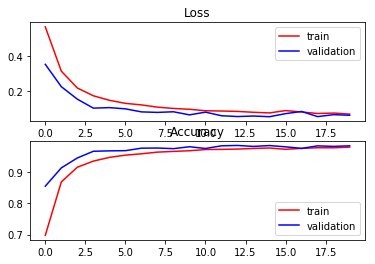

In [84]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

In [86]:
final_model_name = get_model_file("/output/", "resnet50_cropped_hard_train", "dot", "final")
#best_model_name = get_model_file("/output/", "resnet50_cropped", "dot", "best")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

#scores[1, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

=== Evaluating model: resnet50_cropped_hard_train-dot-final.h5 ===

Accuracy: 0.983

Confusion Matrix
[[11233   347]
 [   52 11504]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     11580
          1       0.97      1.00      0.98     11556

avg / total       0.98      0.98      0.98     23136

=== Evaluating model: resnet50_cropped_hard_train-dot-best.h5 ===

Accuracy: 0.982

Confusion Matrix
[[11223   355]
 [   63 11495]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.97      0.98     11578
          1       0.97      0.99      0.98     11558

avg / total       0.98      0.98      0.98     23136



In [87]:
import pandas as pd
def evaluate_test_b_simple_ave(model_file, image_dir, test_b_dir, vec_size, vec_dict_test_b, vec_dict, batch_size):
    model_name = os.path.basename(model_file)
    model = load_model(model_file)
    print("=== Evaluating model test a: {:s} ===".format(model_name))
    image_names_rev = [x for x in os.listdir(image_dir) if not (x.startswith('.'))]
    test_b_names = [x for x in os.listdir(test_b_dir) if not (x.startswith('.'))]
    X1 = np.zeros((len(image_names_rev), vec_size))
    X2 = np.zeros((len(image_names_rev), vec_size))
    #Y = np.zeros((len(batch), 2))
    #test_b_names_new = []
    #image_names_new = []
    ypred = []
    for j, test_b_name in enumerate(test_b_names):
        test_b_names_new = []
        image_names_new = []
        for i, image_name in enumerate(image_names_rev):
            X1[i] = vec_dict_test_b[test_b_name]
            X2[i] = vec_dict[image_name]
            test_b_names_new.append(test_b_name[0:-4])
            image_names_new.append(image_name[0:-4])
        Y_ = model.predict([X1, X2])
        Y_s = [x[1] for x in Y_] 
        #ypred.extend((Y_s))

        DF = pd.DataFrame({"probability": Y_s, "ImageGroup": image_names_new,
              "test_image_ID": test_b_names_new
              })
        DF = DF[['test_image_ID', 'ImageGroup', 'probability']]

        DF.to_csv("/output/test_b_cropped_hard_train_f.csv",
                        sep=',', encoding="utf-8", index = False,
                        header = False, mode = "a")
        if j%100 ==0:
            print("the %d test image is in processing" %j)

    return Y_s, test_b_names_new,image_names_new
            

In [88]:
ypred, test_b_names, image_names = evaluate_test_b_simple_ave(final_model_name,IMAGE_DIR, TEST_B_DIR, VECTOR_SIZE, vec_dict_test_b, vec_dict, BATCH_SIZE )

=== Evaluating model test a: resnet50_cropped_hard_train-dot-final.h5 ===
the 0 test image is in processing
the 100 test image is in processing
the 200 test image is in processing
the 300 test image is in processing
the 400 test image is in processing
the 500 test image is in processing
the 600 test image is in processing
the 700 test image is in processing
the 800 test image is in processing
the 900 test image is in processing
the 1000 test image is in processing
the 1100 test image is in processing
the 1200 test image is in processing
the 1300 test image is in processing
the 1400 test image is in processing
the 1500 test image is in processing
the 1600 test image is in processing
the 1700 test image is in processing
the 1800 test image is in processing
the 1900 test image is in processing
the 2000 test image is in processing
the 2100 test image is in processing
the 2200 test image is in processing
the 2300 test image is in processing
the 2400 test image is in processing
the 2500 test